In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd 
import matplotlib.pyplot as plt
import seaborn as sns
import contextily
import plotly.express as px

/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
df = gpd.read_file('../raw_data/df_with_bez/merged_bez.shp')
df.dropna(inplace=True)

In [35]:
df = df.rename(
    columns={
        'BEZ': 'Bezirk',
        'child_pov': 'Child poverty',
        'mig_rate': 'Migration rate',
        'unemployme': 'Unemployment',
        'welfare': 'Social benefits',
        'ave_rent': 'Average rent',
        'social_hou': 'Social housing',
        'public_hou': 'Public housing'
    })

In [4]:
df.Bezirk = df.Bezirk.map({
    '01': 'Mitte',
    '02': 'Friedrichshain-Kreuzberg',
    '03': 'Pankow',
    '04': 'Charlottenburg-Wilmersdorf',
    '05': 'Spandau',
    '06': 'Steglitz-Zehlendorf',
    '07': 'Tempelhof-Schöneberg',
    '08': 'Neukölln',
    '09': 'Treptow-Köpenick',
    '10': 'Marzahn-Hellersdorf',
    '11': 'Lichtenberg',
    '12': 'Reinickendorf'
})

<Figure size 432x288 with 0 Axes>

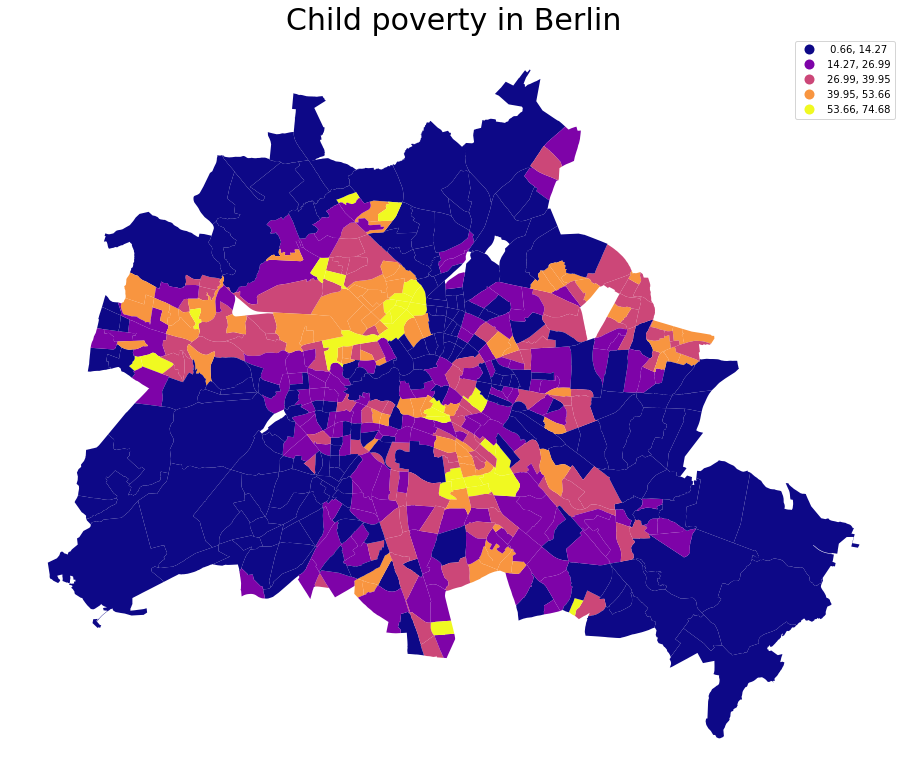

In [5]:
fig = plt.figure()
ax = df.plot(figsize=(16,16), column='Child poverty', cmap='plasma', scheme='NaturalBreaks', legend=True)
ax.set_facecolor("yellow")
ax.set_axis_off()
ax.set_title('Child poverty in Berlin', fontsize=30)
plt.savefig(fname='plots/child_pov.svg',transparent=False)

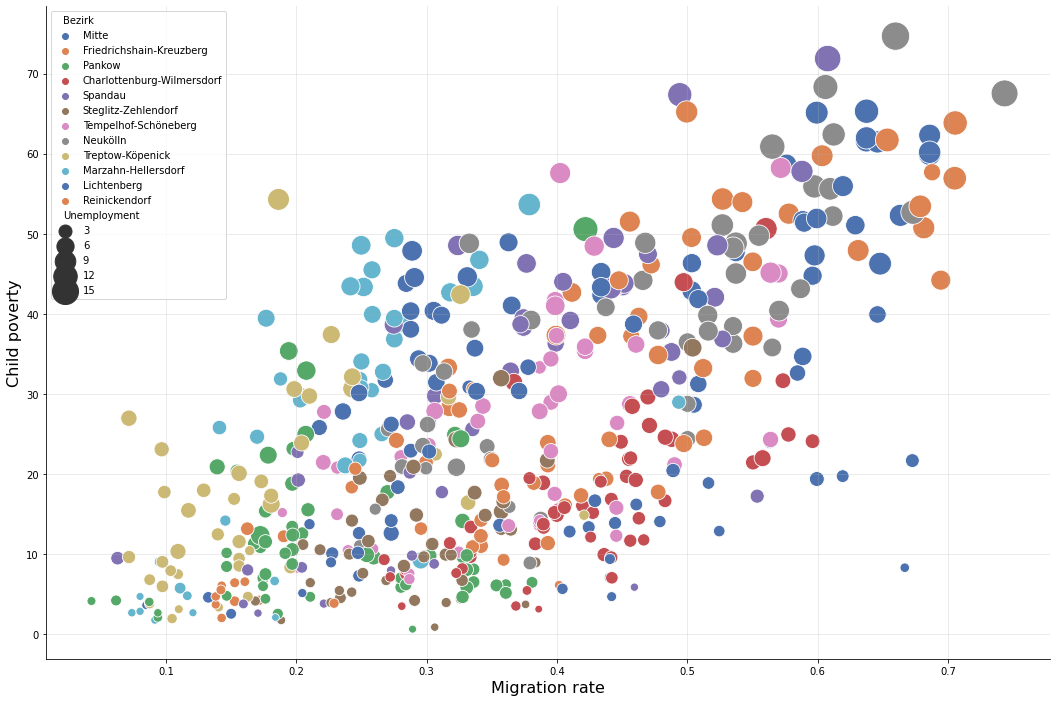

In [6]:
fig = plt.figure(figsize=(18, 12))
ax = sns.scatterplot(x="Migration rate",
                y="Child poverty",
                hue='Bezirk',
                size="Unemployment",
                hue_order=[
                    'Mitte', 'Friedrichshain-Kreuzberg', 'Pankow',
                    'Charlottenburg-Wilmersdorf', 'Spandau',
                    'Steglitz-Zehlendorf', 'Tempelhof-Schöneberg', 'Neukölln',
                    'Treptow-Köpenick', 'Marzahn-Hellersdorf', 'Lichtenberg',
                    'Reinickendorf'
                ],
                palette=sns.color_palette('deep', 12),
                sizes=(60, 800), legend='brief',
                data=df)
ax.grid(alpha=0.3)
ax.spines['right'].set_color(None)
ax.spines['top'].set_color(None)
ax.set_xlabel('Migration rate', fontsize = 16)
ax.set_ylabel('Child poverty', fontsize = 16)
plt.savefig(fname='plots/scatterplot_mig_rate.svg',transparent=False)

In [80]:
list(df.columns)

['PLR_ID',
 'public_tra',
 'eating',
 'culture',
 'community',
 'health_car',
 'public_ser',
 'education',
 'schools',
 'universiti',
 'kindergart',
 'outdoor_fa',
 'outdoor_le',
 'night_life',
 'water',
 'E_E',
 'E_EM',
 'E_EW',
 'E_EU1',
 'E_E1U6',
 'E_E6U15',
 'E_E15U18',
 'E_E18U25',
 'E_E25U55',
 'E_E55U65',
 'E_E65U80',
 'E_E80U110',
 'MH_E',
 'MH_EM',
 'MH_EW',
 'MH_U1',
 'MH_1U6',
 'MH_6U15',
 'MH_15U18',
 'MH_18U25',
 'MH_25U55',
 'MH_55U65',
 'MH_65U80',
 'MH_80U110',
 'Migration rate',
 'HK_EU15',
 'HK_EU28',
 'HK_Polen',
 'HK_EheJug',
 'HK_EheSU',
 'HK_Turk',
 'HK_Arab',
 'HK_Sonst',
 'HK_NZOrd',
 'Average rent',
 'dyn_wel_po',
 'welf_po',
 'Social housing',
 'Public housing',
 'dyn_ew',
 'five_y_pls',
 'rent_to_pr',
 'dyn_r_to_p',
 'sales',
 'dyn_sales',
 'BZR_NAME',
 'EW',
 'Unemployment',
 'Social benefits',
 'Child poverty',
 'dyn_unempl',
 'dyn_welfar',
 'dyn_child',
 'noise',
 'air',
 'green',
 'bio',
 'x_bis_1900',
 'x1901_1910',
 'x1911_1920',
 'x1921_1930',
 'x1931

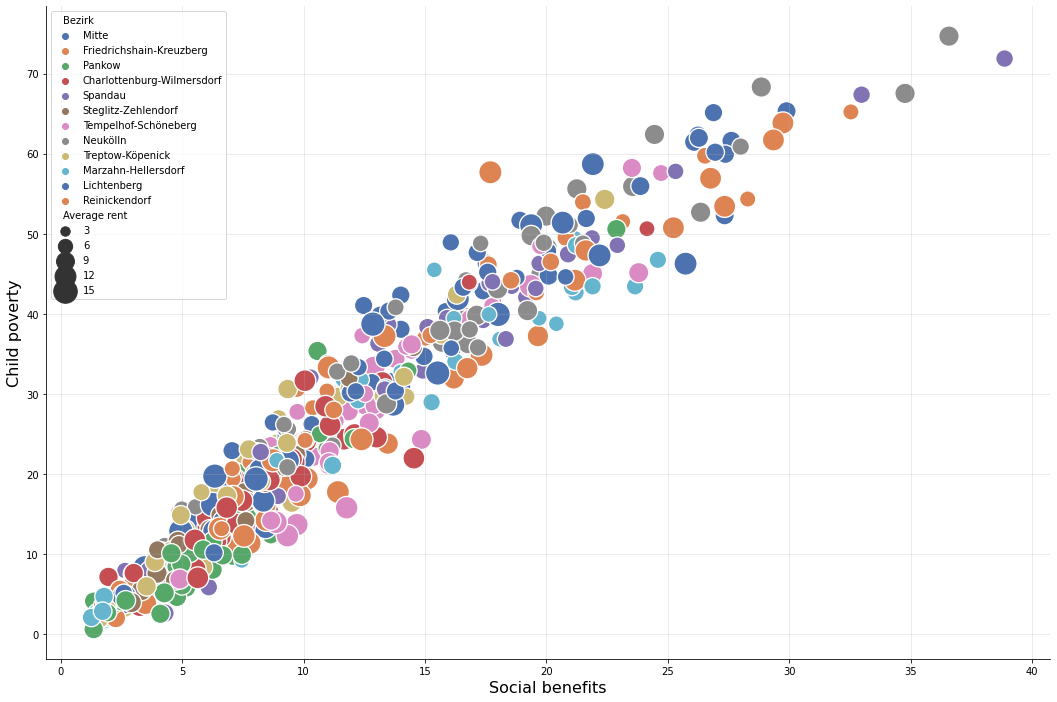

In [86]:
fig = plt.figure(figsize=(18, 12))
ax = sns.scatterplot(x="Social benefits",
                y="Child poverty",
                hue='Bezirk',
                size="Average rent",
                hue_order=[
                    'Mitte', 'Friedrichshain-Kreuzberg', 'Pankow',
                    'Charlottenburg-Wilmersdorf', 'Spandau',
                    'Steglitz-Zehlendorf', 'Tempelhof-Schöneberg', 'Neukölln',
                    'Treptow-Köpenick', 'Marzahn-Hellersdorf', 'Lichtenberg',
                    'Reinickendorf'
                ],
                palette=sns.color_palette('deep', 12),
                sizes=(10,600), legend='brief',
                data=df)
ax.grid(alpha=0.3)
ax.spines['right'].set_color(None)
ax.spines['top'].set_color(None)
ax.set_xlabel('Social benefits', fontsize = 16)
ax.set_ylabel('Child poverty', fontsize = 16)
plt.savefig(fname='plots/scatterplot_social_benefits.svg',transparent=False)

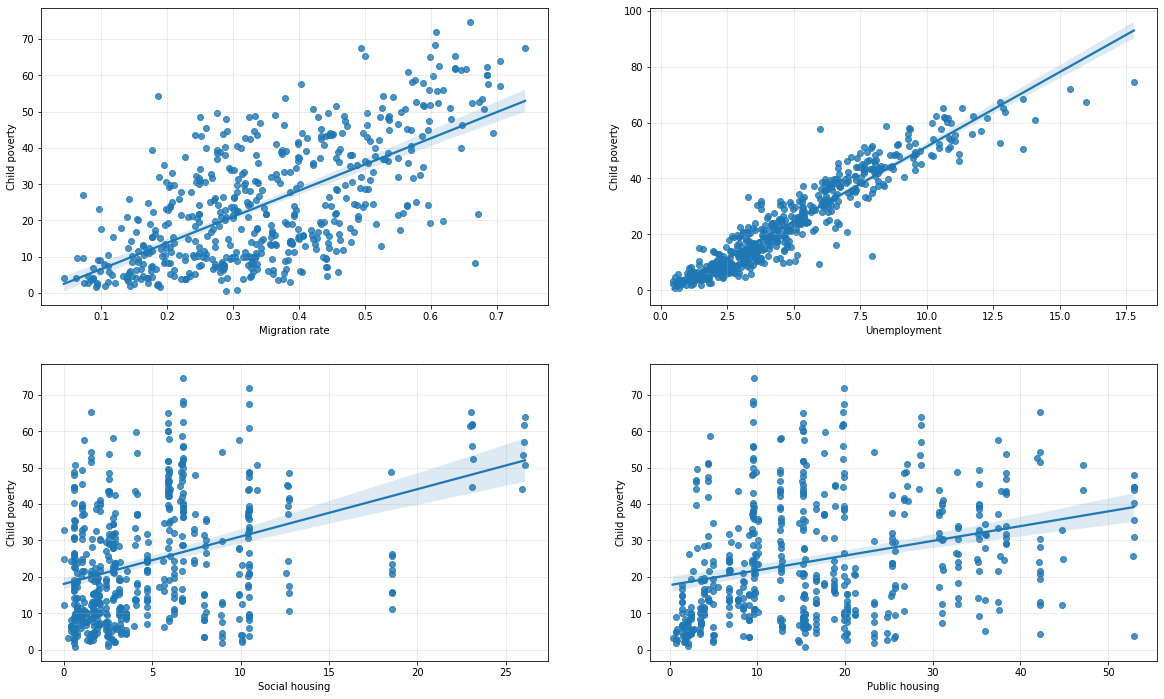

In [37]:
fig=plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.regplot(df['Migration rate'], df['Child poverty'], fit_reg=True)
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(2,2,2)
ax2 = sns.regplot(df['Unemployment'], df['Child poverty'], fit_reg=True)
ax2.grid(alpha=0.3)

ax3 = fig.add_subplot(2,2,3)
ax3 = sns.regplot(df['Social housing'], df['Child poverty'], fit_reg=True)
ax3.grid(alpha=0.3)

ax4 = fig.add_subplot(2,2,4)
ax4 = sns.regplot(df['Public housing'], df['Child poverty'], fit_reg=True)
ax4.grid(alpha=0.3)

plt.savefig(fname='plots/mrate_unempl_social_public.svg',transparent=False)


/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease th

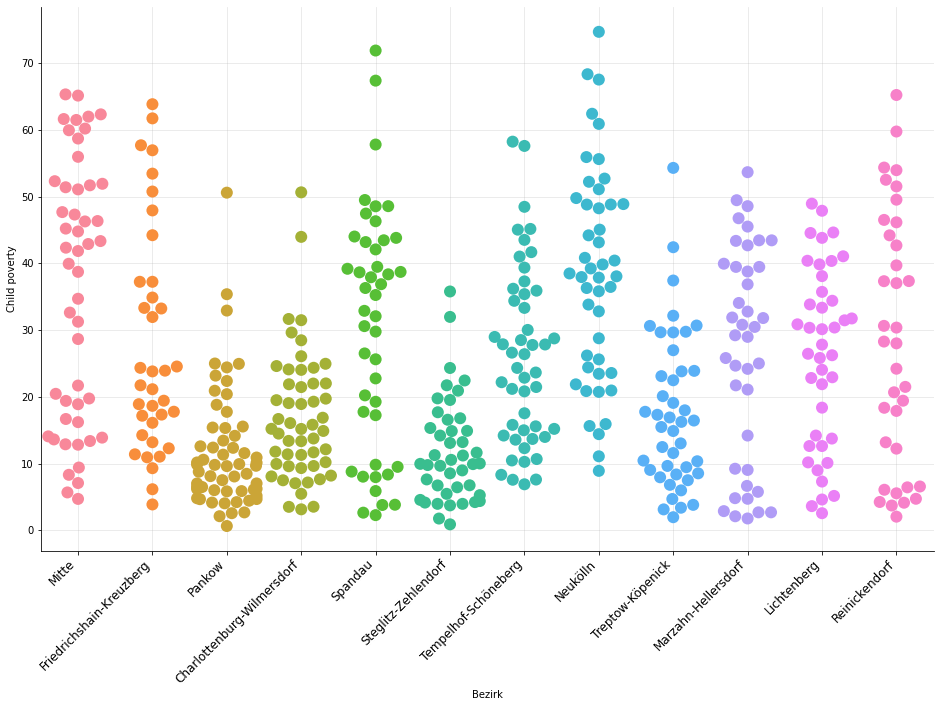

In [74]:
plt.figure(figsize=(16, 10))
ax = sns.swarmplot(data=df,
                   x='Bezirk',
                   y='Child poverty',
                   size=12,
                   order=[
                       'Mitte', 'Friedrichshain-Kreuzberg', 'Pankow',
                       'Charlottenburg-Wilmersdorf', 'Spandau',
                       'Steglitz-Zehlendorf', 'Tempelhof-Schöneberg',
                       'Neukölln', 'Treptow-Köpenick', 'Marzahn-Hellersdorf',
                       'Lichtenberg', 'Reinickendorf'
                   ])
ax.set_xticklabels(ax.get_xticklabels(),fontsize='large',
                   rotation=45,
                   horizontalalignment='right')
ax.grid(alpha=0.3)
ax.spines[['right', 'top']].set_color(None)
plt.savefig(fname='plots/swarmplot_bezirk.svg', transparent=False)

In [88]:
clustering = gpd.read_file('../raw_data/for_models/cluster_gdf.shp')

In [168]:
list(clustering)

['PLR_ID',
 'public_tra',
 'eating',
 'culture',
 'community',
 'health_car',
 'public_ser',
 'education',
 'universiti',
 'outdoor_fa',
 'outdoor_le',
 'night_life',
 'water',
 'E_EU1',
 'E_E1U6',
 'E_E6U15',
 'E_E15U18',
 'E_E18U25',
 'E_E25U55',
 'E_E55U65',
 'E_E65U80',
 'E_E80U110',
 'mig_rate',
 'HK_EU15',
 'HK_EU28',
 'HK_Polen',
 'HK_EheJug',
 'HK_EheSU',
 'HK_Turk',
 'HK_Arab',
 'HK_Sonst',
 'HK_NZOrd',
 'ave_rent',
 'dyn_wel_po',
 'welf_po',
 'social_hou',
 'public_hou',
 'dyn_ew',
 'five_y_pls',
 'rent_to_pr',
 'dyn_r_to_p',
 'sales',
 'dyn_sales',
 'BZR_NAME',
 'unemployme',
 'welfare',
 'child_pov',
 'dyn_unempl',
 'dyn_welfar',
 'dyn_child',
 'noise',
 'air',
 'green',
 'bio',
 'total_buil',
 'B_1940',
 'B_1941_199',
 'B_1991_201',
 'B_age',
 'vegpm20',
 'ch_rate',
 'other_sch',
 'vocat_sch',
 'primary_sc',
 'Gymnasium',
 'secon_sch',
 'priv_schoo',
 'sp_nee_sch',
 'kita',
 'stations',
 'geometry',
 'label']

In [122]:
social_index = ['unemployme', 'welfare', 'child_pov']

In [185]:
migration = ['mig_rate', 'unemployme']

In [170]:
gentrification = [
    'sales', 'ave_rent', 'eating', 'night_life']

In [171]:
infrastructure = [
    'culture', 'stations', 'social_hou', 'public_hou', 'kita', 'vegpm20',
    'outdoor_fa', 'outdoor_le'
]

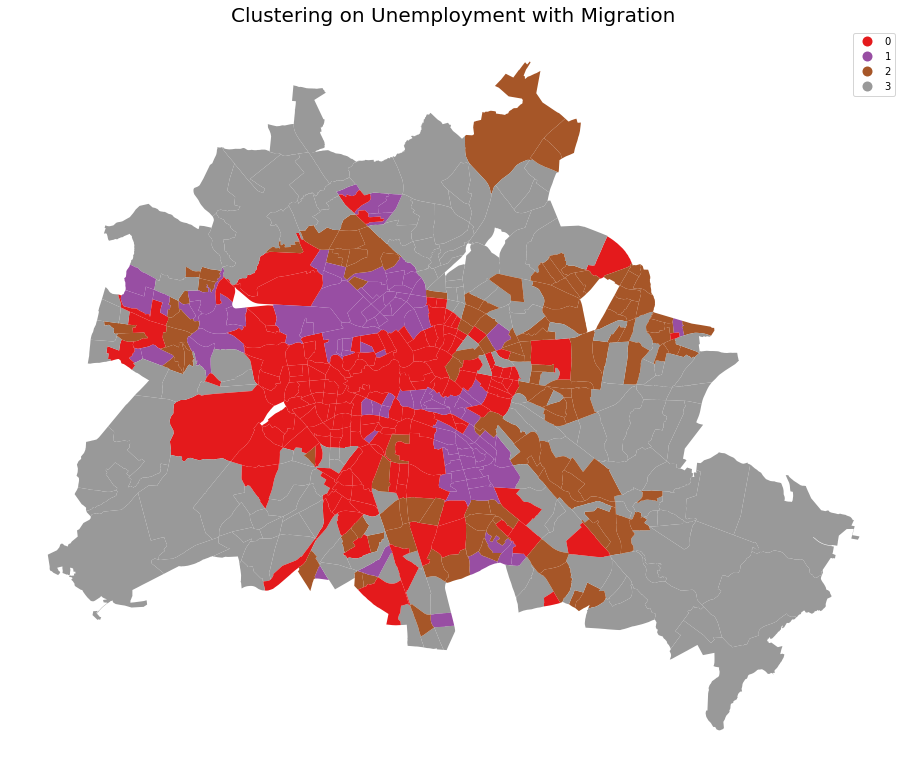

In [192]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(clustering[migration])

# Assign labels into a column
clustering["label"] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(16, 16))
# Plot unique values choropleth including
# a legend and with no boundary lines


clustering.plot(
    column="label", categorical=True, legend=True, ax=ax, cmap = 'Set1'
)
# Remove axis
ax.set_title('Clustering on Unemployment with Migration', fontsize=20)
ax.set_axis_off()
# Display the map
plt.savefig(fname='plots/cluster_migration_unempl.svg', transparent=False)
plt.show()

In [194]:
k5means = clustering.groupby("label")[migration].mean()

k5means = k5means.rename(
    {
        'mig_rate': 'Migration rate', 'unemployme': 'Unemployment'
    },
    axis=1)

k5means.T.round(3)

label,0,1,2,3
Migration rate,0.385,1.063,-0.139,-0.667
Unemployment,-0.186,1.317,0.504,-0.526


In [159]:
k5sizes = clustering.groupby("label").size()
k5sizes

label
0    170
1    129
2    237
dtype: int64